#Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
!pip install torchsummary
import torchsummary
import cv2
import warnings
warnings.filterwarnings('ignore')
!pip install torch-geometric
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.datasets.mnist_superpixels import MNISTSuperpixels
from torch_geometric.datasets import MNISTSuperpixels
import torch_geometric
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_labels_MNIST = {0 : "0", 1 : "1", 2 : "2", 3 : "3", 4 : "4", 5 : "5", 6 : "6", 7 : "7", 8 : "8", 9 : "9"}

In [ ]:
train_set_SP_MNIST = MNISTSuperpixels(
    root = 'data',
    train = True
)

train_set_SP_MNIST, val_set_SP_MNIST = torch.utils.data.random_split(train_set_SP_MNIST,[0.7,0.3])

test_set_SP_MNIST = MNISTSuperpixels(
    root = 'data',
    train = False
)

Extracting data/raw/MNISTSuperpixels.zip
Processing...
Done!


In [ ]:
def build_collate_fn(device: str | torch.device):
    def collate_fn(original_batch: list[Data]):
        batch_node_features: list[torch.Tensor] = []
        batch_edge_indices: list[torch.Tensor] = []
        classes: list[int] = []

        for data in original_batch:
            node_features = torch.cat((data.x, data.pos), dim=-1).to(device)
            edge_indices = data.edge_index.to(device)
            class_ = int(data.y)

            batch_node_features.append(node_features)
            batch_edge_indices.append(edge_indices)
            classes.append(class_)

        collated = {
            "batch_node_features": batch_node_features,
            "batch_edge_indices": batch_edge_indices,
            "classes": torch.LongTensor(classes).to(device),
        }

        return collated
    return collate_fn

In [ ]:
train_loader_SP_MNIST = DataLoader(
    dataset = train_set_SP_MNIST,
    batch_size = 64,
    shuffle = True,
    collate_fn = build_collate_fn(device = device)
)

val_loader_SP_MNIST = DataLoader(
    dataset = val_set_SP_MNIST,
    batch_size = 64,
    shuffle = False,
    collate_fn = build_collate_fn(device = device)
)

test_loader_SP_MNIST = DataLoader(
    dataset = test_set_SP_MNIST,
    batch_size = 64,
    shuffle = False,
    collate_fn = build_collate_fn(device = device)
)

In [ ]:
for b in test_loader_SP_MNIST:
  print(b.keys())
  break

dict_keys(['batch_node_features', 'batch_edge_indices', 'classes'])


# Visualization

In [ ]:
def superpixels_to_2d_image(rec : torch_geometric.data.Data,
                            scale : int = 30,
                            edge_width : int = 1) -> np.ndarray:

    pos = (rec.pos.clone() * scale).int()

    image = np.zeros((scale * 26, scale * 26, 1), dtype = np.uint8)

    for (color, (x, y)) in zip(rec.x, pos):

        x0, y0 = int(x), int(y)
        x1, y1 = x0 - scale, y0 - scale

        color = int(float(color + 0.15) * 255)
        color = min(color, 255)

        cv2.rectangle(image, (x0, y0), (x1, y1), color, -1)

    for node_ix_0, node_ix_1 in rec.edge_index.T:

        x0, y0 = list(map(int, pos[node_ix_0]))
        x1, y1 = list(map(int, pos[node_ix_1]))

        x0 -= scale // 2
        y0 -= scale // 2
        x1 -= scale // 2
        y1 -= scale // 2

        cv2.line(image, (x0, y0), (x1, y1), 125, edge_width)

    return image

In [ ]:
def visualize(
    dataset: MNISTSuperpixels,
    image_name: str,
    examples_per_class: int = 10,
    classes: tuple[int, ...] = tuple(range(10)),
    figsize: tuple[int, int] = (5, 5),
    edge_width: int = 1,
) -> None:
    class_to_examples = {class_ix: [] for class_ix in classes}

    for record in dataset:
        enough = True
        for examples in class_to_examples.values():
            if len(examples) < examples_per_class:
                enough = False
        if enough:
            break

        class_ix = int(record.y)

        if class_ix not in class_to_examples:
            continue

        if len(class_to_examples[class_ix]) == examples_per_class:
            continue

        if len(class_to_examples[class_ix]) > examples_per_class:
            raise RuntimeError

        class_to_examples[class_ix].append(superpixels_to_2d_image(record, edge_width=edge_width))

    plt.figure(figsize=figsize)
    subplot_ix = 1
    for class_ix in classes:
        for example in class_to_examples[class_ix]:
            plt.subplot(len(classes), examples_per_class, subplot_ix)
            subplot_ix += 1
            plt.imshow(example, cmap=plt.cm.binary)
    plt.savefig(image_name)



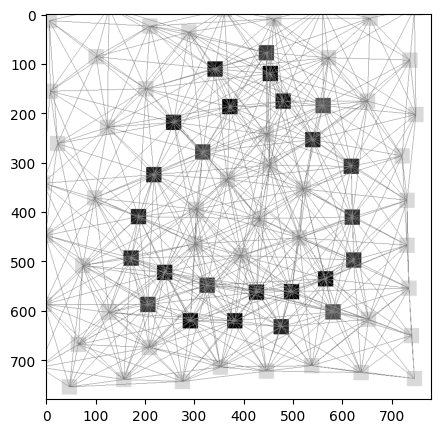

In [ ]:
visualize(
    train_set_SP_MNIST,
    image_name = "one_class.jpg",
    classes = (0,),
    examples_per_class = 1,
)


plt.show()

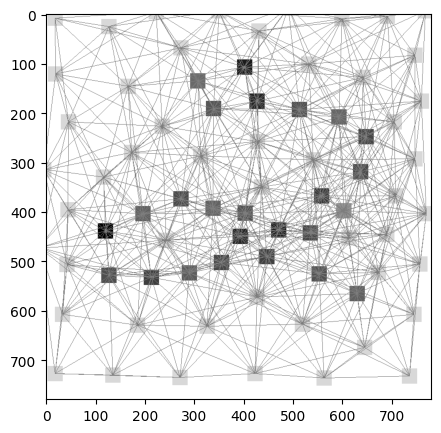

In [ ]:
visualize(
    train_set_SP_MNIST,
    image_name = "two_class.jpg",
    classes = (2,),
    examples_per_class = 1,
)


plt.show()

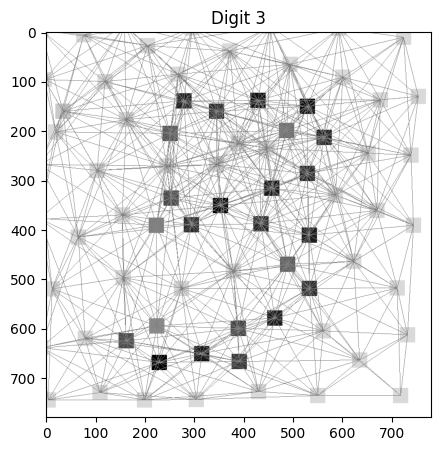

In [ ]:
visualize(
    train_set_SP_MNIST,
    image_name = "three_class.jpg",
    classes = (3,),
    examples_per_class = 1,
)

plt.title("Digit 3")

plt.show()

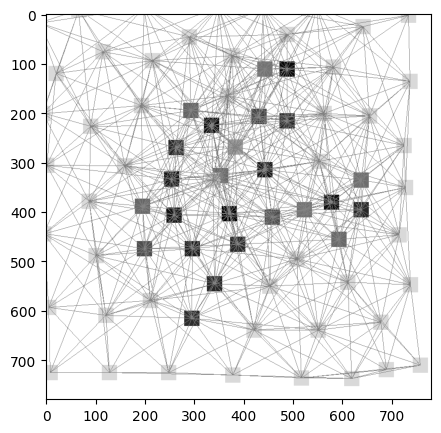

In [ ]:
visualize(
    train_set_SP_MNIST,
    image_name = "four_class.jpg",
    classes = (4,),
    examples_per_class = 1,
)


plt.show()

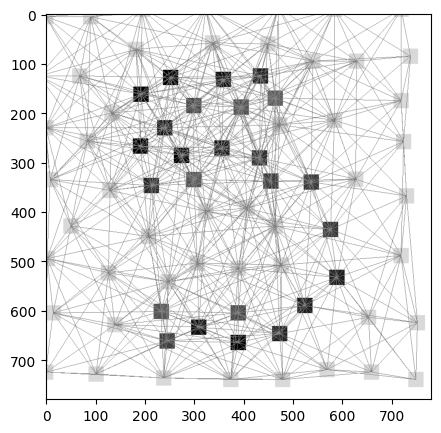

In [ ]:
visualize(
    train_set_SP_MNIST,
    image_name = "five_class.jpg",
    classes = (5,),
    examples_per_class = 1,
)


plt.show()

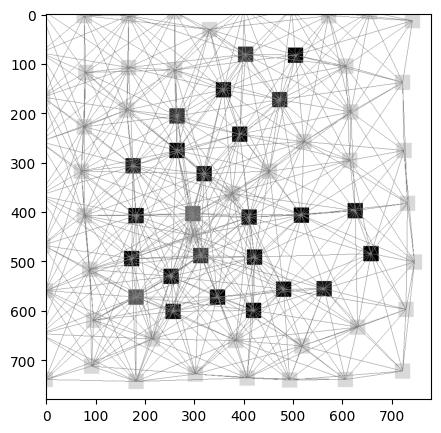

In [ ]:
visualize(
    train_set_SP_MNIST,
    image_name = "six_class.jpg",
    classes = (6,),
    examples_per_class = 1,
)


plt.show()

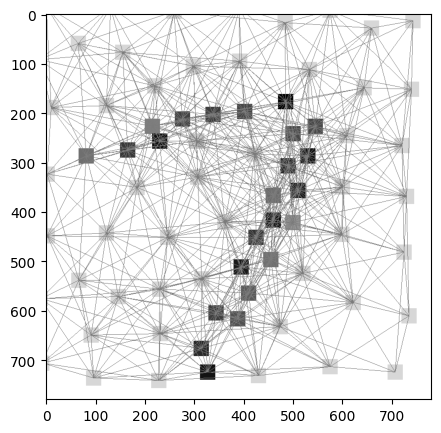

In [ ]:
visualize(
    train_set_SP_MNIST,
    image_name = "seven_class.jpg",
    classes = (7,),
    examples_per_class = 1,
)


plt.show()

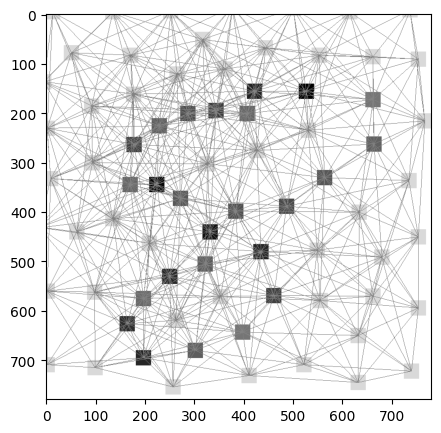

In [ ]:
visualize(
    train_set_SP_MNIST,
    image_name = "eight_class.jpg",
    classes = (8,),
    examples_per_class = 1,
)

plt.show()

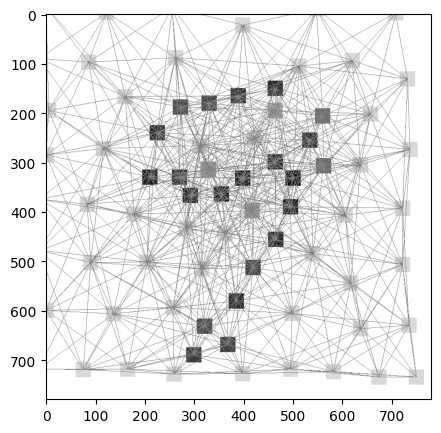

In [ ]:
visualize(
    train_set_SP_MNIST,
    image_name = "nine_class.jpg",
    classes = (9,),
    examples_per_class = 1,
)

plt.show()

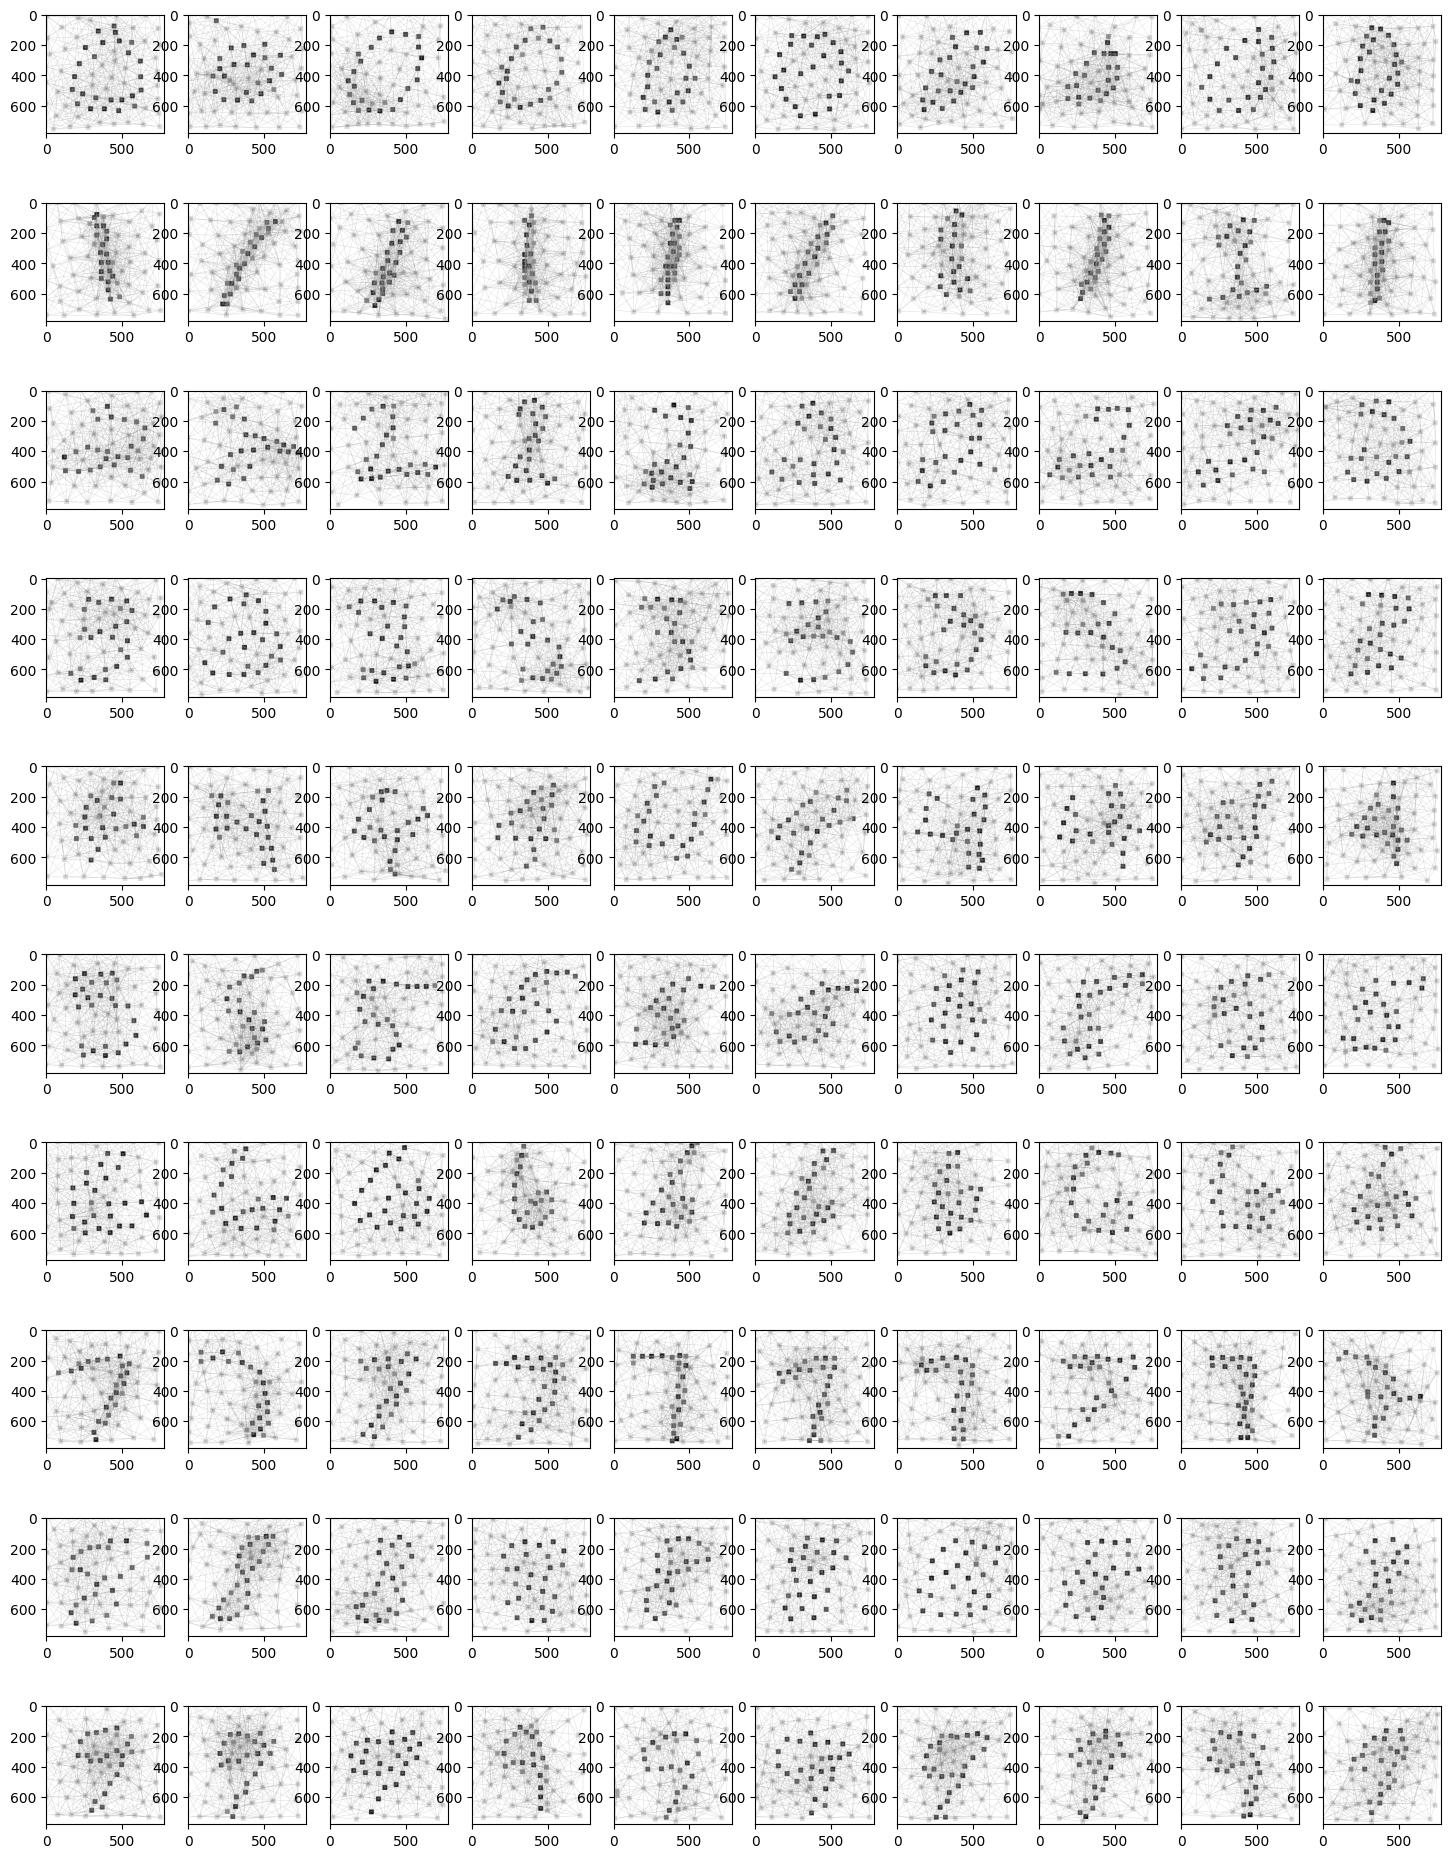

In [ ]:
visualize(
    train_set_SP_MNIST,
    image_name="all_classes.jpg",
    figsize = (18,24),
)

#Architechture

In [ ]:
class GNNImageClassificator(nn.Module):

    def __init__(self,
                 input_channels: int = 3,
                 hidden_dimension: int = 152,
                 num_classes: int = 10):

        super(GNNImageClassificator, self).__init__()

        self.input_channels = input_channels
        self.hidden_dimension = hidden_dimension
        self.num_classes = num_classes

        self.Conv1 = GATConv(in_channels=input_channels, out_channels=hidden_dimension)
        self.Conv2 = GATConv(in_channels=hidden_dimension, out_channels=hidden_dimension)
        self.Conv3 = GATConv(in_channels=hidden_dimension, out_channels=hidden_dimension)
        self.Conv4 = GATConv(in_channels=hidden_dimension, out_channels=hidden_dimension)
        self.Conv5 = GATConv(in_channels=hidden_dimension+input_channels, out_channels=hidden_dimension)

        self.FC = nn.Sequential(
            nn.Linear(input_channels + 5 * hidden_dimension, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes)
        )

    def forward_one_base(self,
                         node_features: torch.Tensor,
                         edge_indices: torch.Tensor) -> torch.Tensor:

        assert node_features.ndim == 2 and node_features.shape[1] == self.input_channels
        assert edge_indices.ndim == 2 and edge_indices.shape[0] == 2

        x0 = node_features

        x1 = self.Conv1(x0, edge_indices)
        x2 = self.Conv2(x1, edge_indices)
        x3 = self.Conv3(x2, edge_indices)
        x4 = self.Conv4(x3, edge_indices)
        x0_x4 = torch.cat((x0, x4), dim=-1)
        x5 = self.Conv5(x0_x4, edge_indices)

        x = torch.cat((x0, x1, x2, x3, x4, x5), dim=-1)

        return x



    def forward(self,
                batch_node_features: list[torch.Tensor],
                batch_edge_indices: list[torch.Tensor]) -> torch.Tensor:

        assert len(batch_node_features) == len(batch_edge_indices)

        features_list = []

        for node_features, edge_indices in zip(batch_node_features, batch_edge_indices):
            features_list.append(self.forward_one_base(node_features=node_features, edge_indices=edge_indices))

        features = torch.stack(features_list, dim=0)
        features = features.mean(dim=1)

        logits = self.FC(features)

        return logits


In [ ]:
model_gnn = GNNImageClassificator().to(device)
print(model_gnn)

GNN(
  (Conv1): GATConv(3, 152, heads=1)
  (Conv2): GATConv(152, 152, heads=1)
  (Conv3): GATConv(152, 152, heads=1)
  (Conv4): GATConv(152, 152, heads=1)
  (Conv5): GATConv(155, 152, heads=1)
  (FC): Sequential(
    (0): Linear(in_features=763, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)


Training and Validation

In [ ]:
learning_rate = 0.001
optimizer = optim.Adam(model_gnn.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()
epochs = 10

In [ ]:
def train_GNN(train_loader, model, optimizer, loss_function):
    model.train()
    total_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        node_features = batch["batch_node_features"]
        edge_indices = batch["batch_edge_indices"]
        classes = batch["classes"]

        logits = model(node_features, edge_indices)
        loss = loss_function(logits, classes)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 131 == 0:
            print(f"     Batch [{batch_idx + 1}/{len(train_loader)}] | Training Loss : {loss.item()}")
    average_loss = total_loss / len(train_loader)

    return average_loss


In [ ]:
def val_GNN(val_loader, model, loss_function):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            node_features = batch["batch_node_features"]
            edge_indices = batch["batch_edge_indices"]
            classes = batch["classes"]

            logits = model(node_features, edge_indices)

            loss = loss_function(logits, classes)
            total_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == classes).sum().item()
            total_samples += classes.size(0)

            if batch_idx % 131 == 0:
                print(f"     Batch [{batch_idx + 1}/{len(val_loader)}] | Validation Loss : {loss.item()}")

    average_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples

    print()
    print(f"Epoch [{epoch + 1}/{epochs}] -> Validation Loss : {average_loss} | Validation Accuracy : {accuracy}")
    print()

    return average_loss, accuracy


In [ ]:
start_gnn = time.time()

train_loss_gnn = np.zeros(epochs)
val_loss_gnn = np.zeros(epochs)
val_accuracy_gnn = np.zeros(epochs)

for epoch in range(epochs):
  print(f"Starting Epoch {epoch + 1}")
  print()

  ith_average_train_loss = train_GNN(train_loader_SP_MNIST, model_gnn, optimizer, loss_function)
  train_loss_gnn[epoch] = ith_average_train_loss
  ith_average_val_loss, ith_average_val_accuracy = val_GNN(val_loader_SP_MNIST, model_gnn, loss_function)
  val_loss_gnn[epoch] = ith_average_val_loss
  val_accuracy_gnn[epoch] = ith_average_val_accuracy

  print()
  print("Epoch [{} /{}] -> Training Loss : {} | Validation Loss : {} | Validation Accuracy : {}".format(epoch + 1,epochs, round(ith_average_train_loss,5), round(ith_average_val_loss,5), round(ith_average_val_accuracy*100,5)))
  print()
  print(f"Ending Epoch {epoch + 1}")
  print()

torch.save(model_gnn.state_dict(), 'gnn')
end_gnn = time.time()

Starting Epoch 1

     Batch [1/657] | Training Loss : 2.2803189754486084
     Batch [132/657] | Training Loss : 2.0384130477905273
     Batch [263/657] | Training Loss : 1.8023083209991455
     Batch [394/657] | Training Loss : 1.793020248413086
     Batch [525/657] | Training Loss : 1.8092066049575806
     Batch [656/657] | Training Loss : 1.6258636713027954

Epoch [1 /10] -> Training Loss : 1.86927 | Validation Loss : 1.54649 | Validation Accuracy : 44.75

Ending Epoch 1

Starting Epoch 2

     Batch [1/657] | Training Loss : 1.7544554471969604
     Batch [132/657] | Training Loss : 1.2733583450317383
     Batch [263/657] | Training Loss : 1.4394121170043945
     Batch [394/657] | Training Loss : 1.5282143354415894
     Batch [525/657] | Training Loss : 1.2510778903961182
     Batch [656/657] | Training Loss : 1.3179692029953003

Epoch [2 /10] -> Training Loss : 1.45569 | Validation Loss : 1.48565 | Validation Accuracy : 47.57778

Ending Epoch 2

Starting Epoch 3

     Batch [1/657]

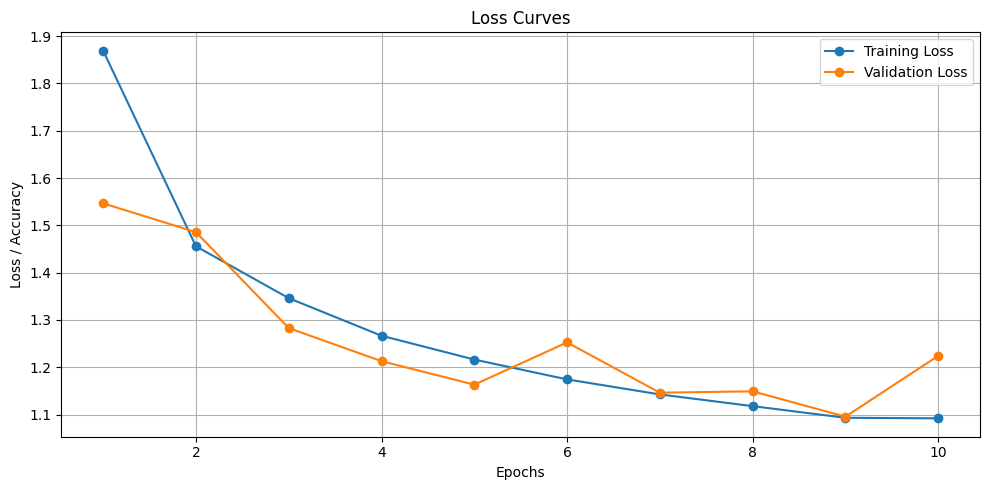

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_gnn, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_loss_gnn, label='Validation Loss', marker='o')

plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
end_gnn - start_gnn

9638.480530261993

# Testing

In [ ]:
def test_GNN(test_loader, model, loss_function):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    losses = []

    with torch.no_grad():
        for batch in test_loader:
            node_features = batch["batch_node_features"]
            edge_indices = batch["batch_edge_indices"]
            classes = batch["classes"]

            logits = model(node_features, edge_indices)
            loss = loss_function(logits, classes)
            total_loss += loss.item()
            losses.append(loss.item())

            predicted_classes = torch.argmax(logits, dim=1)
            total_correct += (predicted_classes == classes).sum().item()
            total_samples += len(classes)

    average_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples

    return average_loss, accuracy


test_loss, test_accuracy = test_GNN(test_loader_SP_MNIST, model_gnn, loss_function)
print(f"Average Test Loss: {test_loss}, Test Accuracy: {test_accuracy*100}")

Average Test Loss: 1.0946640498389378, Test Accuracy: 50.18%


#Hyper Parameter Tuning

Training with Set 1 hyperparameters:
     Batch [1/657] | Training Loss : 2.3066904544830322
     Batch [132/657] | Training Loss : 2.3336269855499268
     Batch [263/657] | Training Loss : 2.2969422340393066
     Batch [394/657] | Training Loss : 2.302440643310547
     Batch [525/657] | Training Loss : 2.3122332096099854
     Batch [656/657] | Training Loss : 2.2872471809387207
Epoch [1/10], Train Loss: 2.3051, Val Loss: 2.3017, Val Accuracy: 0.1132
     Batch [1/657] | Training Loss : 2.30288028717041
     Batch [132/657] | Training Loss : 2.2980873584747314
     Batch [263/657] | Training Loss : 2.3083252906799316
     Batch [394/657] | Training Loss : 2.293473720550537
     Batch [525/657] | Training Loss : 2.2590134143829346
     Batch [656/657] | Training Loss : 2.1941182613372803
Epoch [2/10], Train Loss: 2.2753, Val Loss: 2.1429, Val Accuracy: 0.2152
     Batch [1/657] | Training Loss : 2.050459146499634
     Batch [132/657] | Training Loss : 2.293184995651245
     Batch [263/6

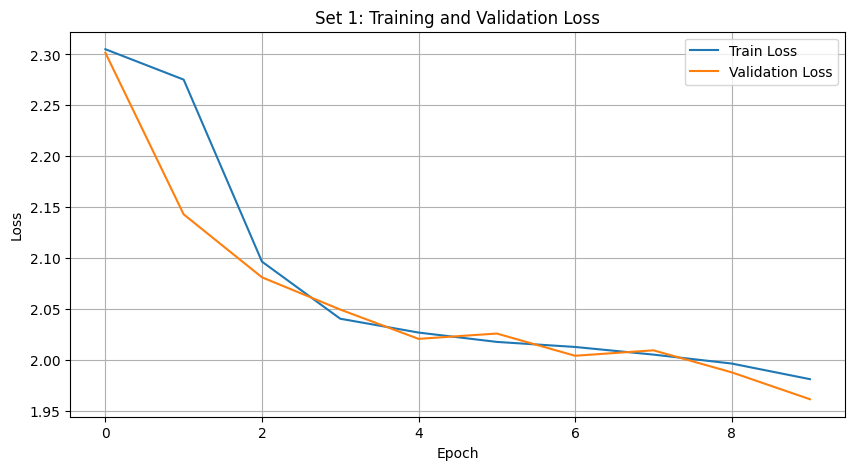

In [ ]:
learning_rate_1 = 0.0001
optimizer_1 = optim.Adam(model_gnn.parameters(), lr=learning_rate_1)
print("Training with Set 1 hyperparameters:")
train_loss_set1 = []
val_loss_set1 = []

for epoch in range(epochs):
    train_loss = train_GNN(train_loader_SP_MNIST, model_gnn, optimizer_1, loss_function)
    train_loss_set1.append(train_loss)
    val_loss, val_accuracy = val_GNN(val_loader_SP_MNIST, model_gnn, loss_function)
    val_loss_set1.append(val_loss)

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_loss_set1, label='Train Loss')
plt.plot(val_loss_set1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Set 1: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test_loss_set1, test_accuracy_set1 = test_GNN(test_loader_SP_MNIST, model_gnn, loss_function)
print(f"Set 1: Average Test Loss: {test_loss_set1}, Test Accuracy: {test_accuracy_set1 * 100:.2f}%")

Set 1: Average Test Loss: 1.9466404998378388, Test Accuracy: 28.13%


Training with Set 2 hyperparameters:
     Batch [1/657] | Training Loss : 1.8537439107894897
     Batch [132/657] | Training Loss : 1.9069064855575562
     Batch [263/657] | Training Loss : 1.9221339225769043
     Batch [394/657] | Training Loss : 1.8073171377182007
     Batch [525/657] | Training Loss : 1.8176223039627075
     Batch [656/657] | Training Loss : 1.9456112384796143
Epoch [1/10], Train Loss: 1.9559, Val Loss: 2.3778, Val Accuracy: 0.1628
     Batch [1/657] | Training Loss : 2.4371860027313232
     Batch [132/657] | Training Loss : 1.7693328857421875
     Batch [263/657] | Training Loss : 1.7990940809249878
     Batch [394/657] | Training Loss : 2.063554048538208
     Batch [525/657] | Training Loss : 1.8990764617919922
     Batch [656/657] | Training Loss : 1.7965017557144165
Epoch [2/10], Train Loss: 1.9492, Val Loss: 2.0534, Val Accuracy: 0.2514
     Batch [1/657] | Training Loss : 2.0816855430603027
     Batch [132/657] | Training Loss : 1.9027680158615112
     Batch [

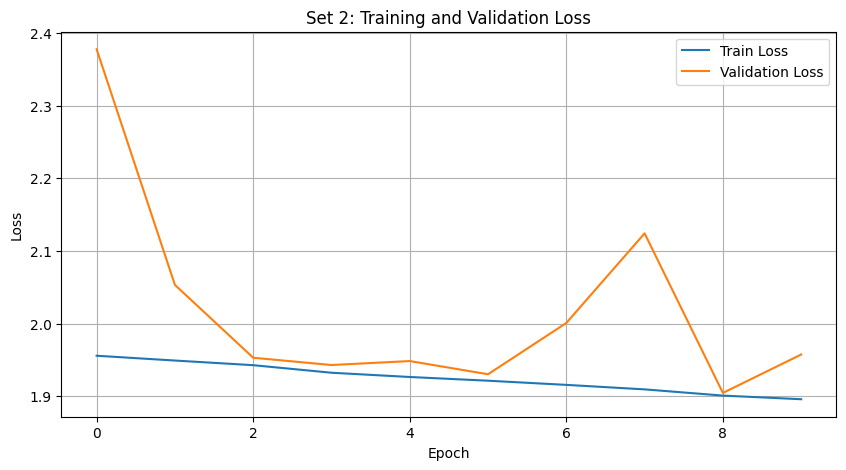

In [ ]:
learning_rate_2 = 0.001
optimizer_2 = optim.SGD(model_gnn.parameters(), lr=learning_rate_2)

print("Training with Set 2 hyperparameters:")
train_loss_set2 = []
val_loss_set2 = []

for epoch in range(epochs):
    train_loss = train_GNN(train_loader_SP_MNIST, model_gnn, optimizer_2, loss_function)
    train_loss_set2.append(train_loss)
    val_loss, val_accuracy = val_GNN(val_loader_SP_MNIST, model_gnn, loss_function)
    val_loss_set2.append(val_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(train_loss_set2, label='Train Loss')
plt.plot(val_loss_set2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Set 2: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test_loss_set2, test_accuracy_set2 = test_GNN(test_loader_SP_MNIST, model_gnn, loss_function)
print(f"Set 2: Average Test Loss: {test_loss_set2}, Test Accuracy: {test_accuracy_set2 * 100:.2f}%")

Set 2: Average Test Loss: 1.937695926162088, Test Accuracy: 30.66%


# Convolutional Neural Network (CNN)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 87560809.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 74590944.47it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28383251.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12977199.43it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.cnn5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()

        self.fc = nn.Linear(256 * 7 * 7, 10)

    def forward(self, x):
        out = self.maxpool1(self.relu1(self.cnn1(x)))
        out = self.maxpool2(self.relu2(self.cnn2(out)))
        out = self.relu3(self.cnn3(out))
        out = self.relu4(self.cnn4(out))
        out = self.relu5(self.cnn5(out))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = CNNModel()


In [ ]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/10], Train Loss: 1.9190, Train Accuracy: 41.39%, Val Loss: 0.5391
Epoch [2/10], Train Loss: 0.3412, Train Accuracy: 89.29%, Val Loss: 0.2440
Epoch [3/10], Train Loss: 0.1945, Train Accuracy: 93.97%, Val Loss: 0.1667
Epoch [4/10], Train Loss: 0.1430, Train Accuracy: 95.63%, Val Loss: 0.1315
Epoch [5/10], Train Loss: 0.1165, Train Accuracy: 96.42%, Val Loss: 0.1087
Epoch [6/10], Train Loss: 0.0977, Train Accuracy: 97.00%, Val Loss: 0.0992
Epoch [7/10], Train Loss: 0.0862, Train Accuracy: 97.30%, Val Loss: 0.0869
Epoch [8/10], Train Loss: 0.0765, Train Accuracy: 97.65%, Val Loss: 0.0800
Epoch [9/10], Train Loss: 0.0688, Train Accuracy: 97.88%, Val Loss: 0.0744
Epoch [10/10], Train Loss: 0.0629, Train Accuracy: 98.03%, Val Loss: 0.0760
Training finished in 1618.68 seconds
Training finished in 1618.68 seconds
Testing finished in 1630.20 seconds
Accuracy of the network on the 10000 test images: 97.83%


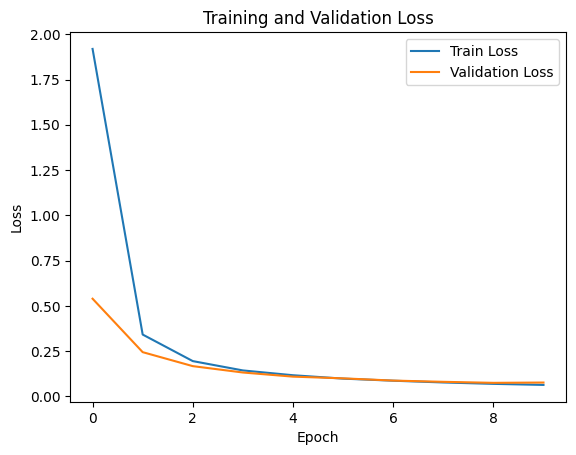

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = 100 * correct / total

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_losses[-1]:.4f}")

end_time = time.time()
print(f"Training finished in {(end_time - start_time):.2f} seconds")

print(f"Training finished in {(end_time - start_time):.2f} seconds")

correct = 0
total = 0


with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end_time = time.time()
print(f"Testing finished in {(end_time - start_time):.2f} seconds")
print(f"Accuracy of the network on the 10000 test images: {(100 * correct / total):.2f}%")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


#  Comparison

Accuracy Comparison
Accuracy on the Test Set of MNIST (10000 Test Samples)

Both GNN and CNN were trained for 10 epochs
GNN : 50.18% Time: 9638 sec(on cpu)
CNN : 97.83% Time: 1618 sec

Clearly, the CNN has performed better than GNN by a signifcant amount. This is because GNN requires so much time to train and more number of epochs, then GNN will get better results.

Time Comparison

Time required to train on the Train Set of MNIST
and do validation on the Validation Set of MNIST

Both GNN and CNN were trained for 10 epochs1
GNN : 50.18% Time: 9638 sec(on cpu)
CNN : 97.83% Time: 1618 sec

We can see CNN took much less time for training than the GNN. However, this is because GNN has more complex architechture compared to CNN.